# Chapter 4: Transfer Learning And Other Tricks

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [79]:
transfer_model = models.resnet50(pretrained=True) 

## Freezing parameters

In [80]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
    
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])


train_data_path = "../data/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=img_transforms, is_valid_file=check_image)
train_data
val_data_path = "../data/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path, transform=img_transforms, is_valid_file=check_image)
val_data
test_data_path = "../data/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=img_transforms, is_valid_file=check_image)
test_data
batch_size = 64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [81]:
for name, param in transfer_model.named_parameters():
    print(f'name: {name}, param: {param.shape}')
    if("bn" not in name):
        param.requires_grad = False

name: conv1.weight, param: torch.Size([64, 3, 7, 7])
name: bn1.weight, param: torch.Size([64])
name: bn1.bias, param: torch.Size([64])
name: layer1.0.conv1.weight, param: torch.Size([64, 64, 1, 1])
name: layer1.0.bn1.weight, param: torch.Size([64])
name: layer1.0.bn1.bias, param: torch.Size([64])
name: layer1.0.conv2.weight, param: torch.Size([64, 64, 3, 3])
name: layer1.0.bn2.weight, param: torch.Size([64])
name: layer1.0.bn2.bias, param: torch.Size([64])
name: layer1.0.conv3.weight, param: torch.Size([256, 64, 1, 1])
name: layer1.0.bn3.weight, param: torch.Size([256])
name: layer1.0.bn3.bias, param: torch.Size([256])
name: layer1.0.downsample.0.weight, param: torch.Size([256, 64, 1, 1])
name: layer1.0.downsample.1.weight, param: torch.Size([256])
name: layer1.0.downsample.1.bias, param: torch.Size([256])
name: layer1.1.conv1.weight, param: torch.Size([64, 256, 1, 1])
name: layer1.1.bn1.weight, param: torch.Size([64])
name: layer1.1.bn1.bias, param: torch.Size([64])
name: layer1.1.con

## Replacing the classifier

In [82]:
transfer_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [83]:
transfer_model.layer4

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): 

In [84]:
transfer_model.fc = nn.Sequential(nn.Linear(2048,500),
nn.ReLU(),                                 
nn.Dropout(), nn.Linear(500,2)) 

## Training Again

In [95]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [105]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])
train_data_path = "../data/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)
val_data_path = "../data/val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)
batch_size=64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

if torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")

In [106]:
print(len(val_data_loader.dataset))

102


In [154]:
for batch in val_data:
    a=0
    print(type(batch))
    print(batch[1])
    a+=1
    if a==1:
        break

<class 'tuple'>
0


In [107]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

In [108]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [114]:
# optimizer = optim.Adam([ { 'params': transfer_model.layer4.parameters(), 'lr': 0.0003 /3}, { 'params': transfer_model.layer3.parameters(), 'lr': 0.0003 /9},
# 
# ], lr=0.0003)

In [115]:
# unfreeze_layers = [transfer_model.layer3, transfer_model.layer4]
# for layer in unfreeze_layers:
#     for param in layer.parameters():
#         param.requires_grad = True

In [116]:
device

device(type='mps')

In [117]:
%time train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader, val_data_loader, epochs=5, device=device)

/var/folders/74/rcykwfcx5bq6vwfd93bqrhgm0000gn/T/ipykernel_62845/652705253.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)


Epoch: 1, Training Loss: 0.01, Validation Loss: 0.18, accuracy = 0.93
Epoch: 2, Training Loss: 0.01, Validation Loss: 0.19, accuracy = 0.93
Epoch: 3, Training Loss: 0.01, Validation Loss: 0.21, accuracy = 0.92
Epoch: 4, Training Loss: 0.02, Validation Loss: 0.16, accuracy = 0.95
Epoch: 5, Training Loss: 0.00, Validation Loss: 0.09, accuracy = 0.96
CPU times: user 13.9 s, sys: 1.56 s, total: 15.5 s
Wall time: 23 s


## LR Finder

In [103]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    print(f'update_step: {update_step}')
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        print(f'log_lrs: {log_lrs[10:-5]} losses: {losses[10:-5]}')
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses


update_step: 5.62341325190349


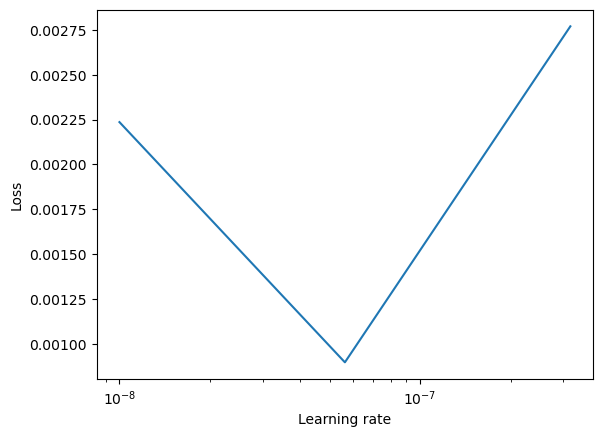

In [104]:
(lrs, losses) = find_lr(transfer_model, torch.nn.CrossEntropyLoss(),optimizer, train_data_loader,device=device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

 ## Custom Transforms

Here we'll create a lambda transform and a custom transform class.

In [118]:
def _random_colour_space(x):
    output = x.convert("HSV")
    return output 

In [119]:
colour_transform = transforms.Lambda(lambda x: _random_colour_space(x))

In [120]:
random_colour_transform = torchvision.transforms.RandomApply([colour_transform])

In [121]:
class Noise():
    """Adds gaussian noise to a tensor.
    
    Example:
        >>> transforms.Compose([
        >>>     transforms.ToTensor(),
        >>>     Noise(0.1, 0.05)),
        >>> ])
    
    """
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        noise = torch.zeros_like(tensor).normal_(self.mean, self.stddev)
        return tensor.add_(noise)
    
    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},sttdev={self.stddev})"
        return repr

In [122]:
custom_transform_pipeline = transforms.Compose([random_colour_transform, Noise(0.1, 0.05)])

In [123]:
custom_transform_pipeline

Compose(
    RandomApply(
    p=0.5
    Lambda()
)
    Noise(mean=0.1,sttdev=0.05)
)

## Ensembles

Given a list of models, we can produce predictions for each model and then make an average to make a final prediction.

In [125]:
device

device(type='mps')

In [124]:
models_ensemble = [models.resnet50().to(device), models.resnet50().to(device)]
predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble] 
avg_prediction = torch.stack(predictions).mean(0).argmax()

/var/folders/74/rcykwfcx5bq6vwfd93bqrhgm0000gn/T/ipykernel_62845/4119873032.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions = [F.softmax(m(torch.rand(1,3,224,244).to(device))) for m in models_ensemble]


In [137]:
torch.stack(predictions).shape

torch.Size([2, 1, 1000])

In [135]:
type(predictions[0])
predictions[0].shape

torch.Size([1, 1000])

In [126]:
avg_prediction

tensor(92, device='mps:0')

In [155]:
torch.stack(predictions).mean(0)

tensor([[0.0008, 0.0013, 0.0005, 0.0008, 0.0010, 0.0011, 0.0007, 0.0011, 0.0016,
         0.0005, 0.0016, 0.0015, 0.0005, 0.0010, 0.0007, 0.0007, 0.0005, 0.0006,
         0.0005, 0.0012, 0.0019, 0.0013, 0.0012, 0.0020, 0.0008, 0.0014, 0.0016,
         0.0007, 0.0006, 0.0015, 0.0012, 0.0015, 0.0011, 0.0011, 0.0017, 0.0007,
         0.0008, 0.0010, 0.0008, 0.0007, 0.0010, 0.0011, 0.0007, 0.0016, 0.0012,
         0.0010, 0.0005, 0.0010, 0.0008, 0.0007, 0.0010, 0.0013, 0.0009, 0.0013,
         0.0004, 0.0011, 0.0009, 0.0010, 0.0006, 0.0006, 0.0004, 0.0017, 0.0014,
         0.0012, 0.0005, 0.0010, 0.0009, 0.0007, 0.0006, 0.0006, 0.0009, 0.0006,
         0.0005, 0.0008, 0.0007, 0.0012, 0.0005, 0.0011, 0.0019, 0.0007, 0.0007,
         0.0010, 0.0008, 0.0010, 0.0010, 0.0019, 0.0005, 0.0009, 0.0008, 0.0012,
         0.0005, 0.0009, 0.0034, 0.0007, 0.0015, 0.0007, 0.0013, 0.0010, 0.0015,
         0.0008, 0.0011, 0.0012, 0.0011, 0.0007, 0.0011, 0.0013, 0.0016, 0.0007,
         0.0009, 0.0013, 0.0

In [158]:
import torch

# Create a 2D tensor
tensor = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float32)

# Calculate the mean along dimension 0 (rows)
mean_along_rows = torch.mean(tensor, dim=0)

# Calculate the mean along dimension 1 (columns)
mean_along_columns = torch.mean(tensor, dim=1)

print("Mean along rows:", mean_along_rows)
print("Mean along columns:", mean_along_columns)


Mean along rows: tensor([2.5000, 3.5000, 4.5000])
Mean along columns: tensor([2., 5.])


In [160]:
tensor.shape

torch.Size([2, 3])